In [1]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from api_key import ApiKey


In [2]:
# API id and secret
clientId = ApiKey.CLIENT_ID
secret = ApiKey.SECRET

# Set up spotify object
client_credentials_manager = SpotifyClientCredentials(client_id=clientId, client_secret=secret)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [54]:
# get track ids from playlist
def getPlaylistTrackIDs(user, playlist_id):
    ids = []
    playlist = spotify.user_playlist(user, playlist_id)
    for item in playlist['tracks']['items']:
        track = item['track']
        ids.append(track['id'])
    return ids

In [55]:
# get songs from a playlist
songs = []
ids = getPlaylistTrackIDs('benovard', '4ZOvYXdxuxjhxSOsGavzpc')
for id in ids:
    track = spotify.track(id)
    track_features = spotify.audio_features(id)[0]
    track_features['title'] = track['name']
    track_features['artist'] = track['artists'][0]['name']
    songs.append(track_features)

df = pd.DataFrame(songs)

In [56]:
# convert to pandas dataframe
df = df.drop(['type', 'uri', 'track_href', 'analysis_url'], axis=1)
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,title,artist
0,0.504,0.891,6,-5.632,0,0.1370,0.00163,0.001990,0.1480,0.628,153.988,7clyJIrLkEbXUDwj1tC9zz,214520,4,Blood // Water,grandson
1,0.816,0.426,6,-10.788,1,0.2810,0.00002,0.388000,0.1200,0.553,109.977,1B7I1XSXciid0JztNLgH2U,215523,4,Natural,Moe Shop
2,0.527,0.922,9,-2.666,0,0.0728,0.00475,0.000162,0.4220,0.490,95.975,2ZPw5uyVI5m1nSvjQYmf3j,181680,4,Hayloft,Mother Mother
3,0.492,0.964,8,-3.475,1,0.0729,0.00046,0.005820,0.4340,0.703,157.036,6Dgix2xCbnqigfrjulm24R,210160,4,Kids,PUP
4,0.708,0.369,0,-13.966,0,0.1280,0.32700,0.000000,0.0566,0.779,160.214,6BAuys1bPzAqPUEzZ0OAA5,198000,4,These Drugs,Sugar Pine 7


In [57]:
# scale attributes between 0 and 1
scaler = MinMaxScaler()
df['key'] = pd.DataFrame(scaler.fit_transform(df[['key']].values))
df['loudness'] = pd.DataFrame(scaler.fit_transform(df[['loudness']].values))
df['tempo'] = pd.DataFrame(scaler.fit_transform(df[['tempo']].values))
df['duration_ms'] = pd.DataFrame(scaler.fit_transform(df[['duration_ms']].values))
df['time_signature'] = pd.DataFrame(scaler.fit_transform(df[['time_signature']].values))

In [58]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.589390,0.671210,0.492727,0.556198,0.640000,0.078532,0.248744,0.093347,0.199560,0.522829,0.414006,0.163390,0.500000
std,0.158696,0.205575,0.314170,0.185645,0.482418,0.058465,0.281455,0.236007,0.156539,0.241316,0.235598,0.122292,0.100504
min,0.206000,0.256000,0.000000,0.000000,0.000000,0.026600,0.000011,0.000000,0.039300,0.037300,0.000000,0.000000,0.000000
25%,0.492000,0.503500,0.181818,0.471813,0.000000,0.042600,0.010275,0.000000,0.104000,0.323750,0.225451,0.105487,0.500000
50%,0.566000,0.680500,0.545455,0.562637,1.000000,0.055650,0.122000,0.000137,0.141000,0.551000,0.400805,0.140003,0.500000
75%,0.709500,0.861500,0.727273,0.690651,1.000000,0.094325,0.485000,0.015025,0.263250,0.703750,0.624903,0.178896,0.500000
max,0.927000,0.980000,1.000000,1.000000,1.000000,0.315000,0.921000,0.926000,0.889000,0.973000,1.000000,1.000000,1.000000


In [59]:
song_features = df.copy()
song_features = song_features.drop(['title', 'artist', 'id'], axis=1)

In [60]:
# run with up to 15 clusters
SSE = []
K = range(1, 15)
for k in range(1, 15):
    km = KMeans(n_clusters=k)
    km = km.fit(song_features)
    SSE.append(km.inertia_)

In [61]:
for k in range(2, 15):
    clusterer = KMeans(n_clusters=k)
    preds = clusterer.fit_predict(song_features)
    centers = clusterer.cluster_centers_
    #score = silhouette_score(song_features, preds, metric='euclidean')
    #print('for ', k, ' clusters, silhouette score is ', score)

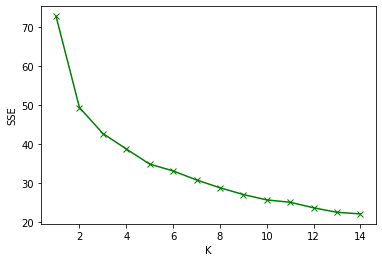

In [62]:
# plot SSE vs K
plt.plot(K, SSE, 'gx-')
plt.xlabel('K')
plt.ylabel('SSE')
plt.show()

In [63]:
# cluster with kmeans
k_means = KMeans(n_clusters=5)
k_means.fit(song_features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [64]:
# dimension reduction with pca
y_kmeans = k_means.predict(song_features)
pca = PCA(n_components=2)
components = pca.fit_transform(song_features)

pc = pd.DataFrame(components)
pc['label'] = y_kmeans
pc.columns = ['x', 'y', 'label']

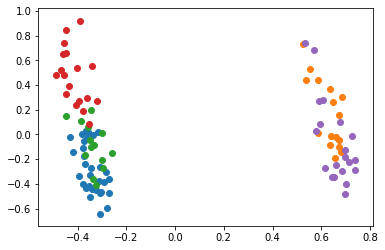

In [65]:
# plot pca reduction
plt.scatter(pc[pc.label == 0].x, pc[pc.label == 0].y)
plt.scatter(pc[pc.label == 1].x, pc[pc.label == 1].y)
plt.scatter(pc[pc.label == 2].x, pc[pc.label == 2].y)
plt.scatter(pc[pc.label == 3].x, pc[pc.label == 3].y)
plt.scatter(pc[pc.label == 4].x, pc[pc.label == 4].y)
plt.scatter(pc[pc.label == 5].x, pc[pc.label == 5].y)
plt.show()

In [66]:
df['cluster'] = y_kmeans

/Users/benovard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


,title,artist,cluster,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
16,Lava,Still Woozy,2,0.623,0.615,0.090909,0.372252,1,0.1460,0.304000,0.008740,0.2500,0.672,0.787485,5BoDFGTXZ8j5muc6Sb2jMz,0.060686,0.5
22,Mr. Brightside,The Killers,2,0.356,0.924,0.090909,0.768368,1,0.0808,0.001010,0.000000,0.0953,0.232,0.620919,7oK9VyNzrYvRFo7nQEYkWN,0.145931,0.5
27,DRUGS,lil aaron,2,0.475,0.776,0.000000,0.705418,1,0.0390,0.000715,0.000000,0.5970,0.561,0.755552,5UShsJdqJLZkl5JNj1ITlP,0.007294,0.5
34,Sedona,Houndmouth,2,0.396,0.677,0.272727,0.532039,1,0.0354,0.037200,0.000137,0.1120,0.249,0.519654,2kG5litgxXvx6ZRgwO1v7W,0.168512,0.5
43,Troubled Mind,Cannibal Kids,2,0.566,0.540,0.000000,0.336236,1,0.0426,0.008250,0.025500,0.0674,0.609,0.755505,1RbdVGt8TF9ovqhTOUO6MG,0.133755,0.5


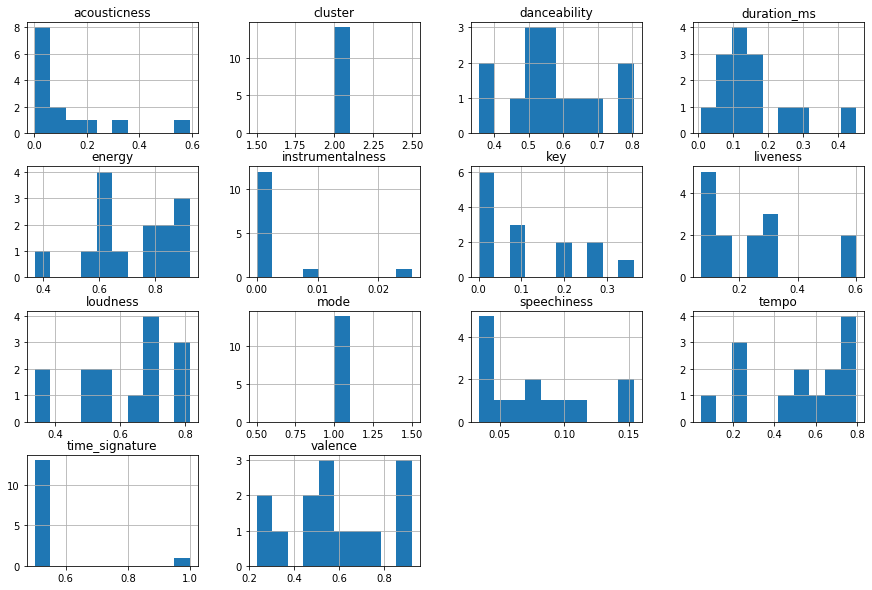

In [77]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
df[df['cluster'] == 2].hist(ax=ax)
cols = [df.columns[-1]] + [col for col in df if col != df.columns[-1]]
df = df[cols]
df[df['cluster'] == 2].head(5)

In [76]:
# add labels to clusters
labels = ["Angry", "Sad", "Vibin", "Dancey", "Chill"]

In [69]:
x = song_features
y = y_kmeans
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [70]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [71]:
knn_pred = knn.predict(x_test)

In [72]:
# plot matrix function pulled from online
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[12  0  0  0  0]
 [ 0  4  0  0  1]
 [ 0  0  5  0  0]
 [ 0  0  1  4  0]
 [ 0  1  0  0  5]]


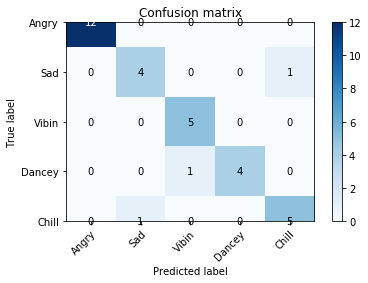

In [73]:
plot_confusion_matrix(y_test, knn_pred, classes=labels)

In [74]:
print(classification_report(y_test, knn_pred, target_names=labels))

              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00        12
         Sad       0.80      0.80      0.80         5
       Vibin       0.83      1.00      0.91         5
      Dancey       1.00      0.80      0.89         5
       Chill       0.83      0.83      0.83         6

    accuracy                           0.91        33
   macro avg       0.89      0.89      0.89        33
weighted avg       0.91      0.91      0.91        33

